In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pymatching
import json
from code_utils import code_initialization, idx_to_coord

def plotter(idx_list, color, marker="o"):
    for idx in (idx_list):
        # print(idx, idx_list[f"{idx}"])
        x, y = idx_list[idx]
        plt.plot(x,y,marker= marker,markersize=10,markerfacecolor="None",markeredgecolor=color)
        plt.text(x,y,idx)


## Logical errro vs Physical error 
Here we simulate the logical error probability as a function of physical error probability when each data qubit is subject to depolarizing channel.

In [7]:

Niter = 10000
d_list = [3,5,7]
p_err_list = np.arange(0.02,0.21,0.02)
logical_err = np.zeros((p_err_list.shape[0],len(d_list)))
p_link = 0.05
for i_d, d in enumerate(d_list):
    print(f"code dist: {d}")
    tic = time.time()
    data_list = {}
    JSON_PATH = f"results/mwpm_sweep_d_{d}_link_{p_link:.3f}.json"
    data_list["p_err"] = p_err_list.tolist()
    
    q_list, sx_list, sz_list = idx_to_coord(d)
    stab_matrices, s_mat, logicals = code_initialization(d)
    inds = np.argwhere(np.random.rand(d**2)<p_link)[:,0]
    s_
    x_stab_to_c,z_stab_to_c,sx_list,sz_list = stab_matrices
    p_err = 0.15
    weights = np.ones(d**2) * np.log((1-p_err)/p_err)
    ind = (d**2-1)//2
    matching_x = pymatching.Matching(s_mat[:ind,:d**2],spacelike_weights=weights)
    matching_z = pymatching.Matching(s_mat[ind:,d**2:],spacelike_weights=weights)

    pauli = [0,1,2,3] # I X Z Y
    for i_p, p_err in enumerate(p_err_list):
        for iter in range(Niter):
            err_instance = np.array(random.choices(pauli, [1-p_err,p_err/3,p_err/3,p_err/3], k=d**2))
            x_err = np.argwhere(err_instance==1)[:,0]
            z_err = np.argwhere(err_instance==2)[:,0]
            y_err = np.argwhere(err_instance==3)[:,0]
            # print(z_err)
            # print(err_instance)

            err_vec = np.zeros(2*d**2)
            if len(x_err)> 0:
                err_vec[x_err] = 1
            if len(z_err)> 0:
                err_vec[d**2 + np.array(z_err)] = 1
            if len(y_err)> 0:
                err_vec[y_err] = 1
                err_vec[d**2 + np.array(y_err)] = 1

            comm_mat = np.kron([[0,1],[1,0]],np.eye(d**2))
            syndrome = (s_mat@ (comm_mat @err_vec)) % 2
            active_syndrome_idx = np.argwhere(syndrome>0)[:,0]

            syndrome_x = syndrome[:ind]
            syndrome_z = syndrome[ind:]

            recovery_x = matching_x.decode(syndrome_x)
            recovery_z = matching_z.decode(syndrome_z)

            idx_recovery_z = np.argwhere(recovery_z>0)[:,0]
            idx_recovery_x = np.argwhere(recovery_x>0)[:,0]

            err_rec = np.copy(err_vec)
            err_rec[idx_recovery_z] += 1
            err_rec[d**2 + idx_recovery_x] += 1
            err_rec %= 2

            logical_err[i_p,i_d] += np.sum(logicals@ (comm_mat @ err_rec) % 2)>0

        logical_err[i_p,i_d] /= Niter
    data_list["logical_err"] = logical_err[:,i_d].tolist()
    with open(JSON_PATH, 'w') as json_file:
        json_file.write(json.dumps(data_list) + '\n')

    toc = time.time()
    print(f"Finished in {toc-tic} sec.")


code dist: 3
Finished in 14.342503547668457 sec.
code dist: 5
Finished in 15.652029275894165 sec.
code dist: 7
Finished in 26.235727071762085 sec.


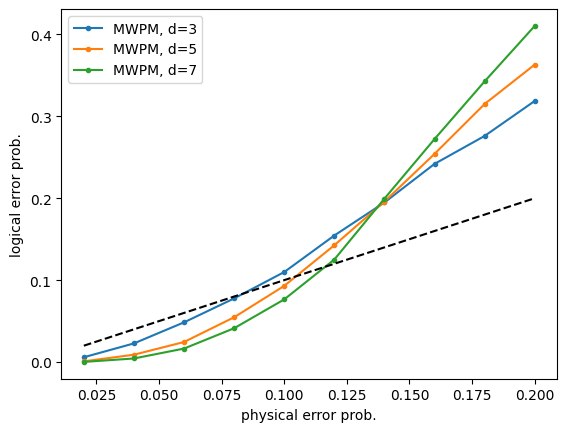

In [8]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

d_list = [3,5,7]
for i_d, d in enumerate(d_list):
    p_err_list,logical_err = mwpm_file_reader(d)
    plt.plot(p_err_list,logical_err,".-", color= f"C{i_d}",label=f"MWPM, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()
plt.show()